In [137]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;}</style>')
%load_ext version_information
%version_information pandas

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.7.1 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
pandas 0.23.4
Wed Feb 13 20:14:43 2019 PST

# Goalie Pull Bayes Optimize

 - Exploratory analysis

## Explore Parsed Goalie Pull Data

In [7]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
import re
import datetime
import time
from collections import OrderedDict
import glob
from tqdm import tqdm_notebook
from colorama import Fore, Style

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['axes.labelpad'] = 10
plt.style.use('ggplot')

In [4]:
df = pd.read_pickle('../data/pkl/20032004_goalie_pulls_2019-02-13.pkl')

In [5]:
df.head()

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta
0,20032004,710,CHI,2004-01-21,3,00:19:44,NaT,00:19:47,NaT,NaT,00:00:03,NaT
1,20032004,205,MIN,2003-11-08,3,00:19:58,NaT,NaT,00:19:58,NaT,NaT,0 days
2,20032004,1230,S.J,2004-04-04,3,00:18:39,00:19:40,NaT,NaT,00:01:01,NaT,NaT
3,20032004,655,PHX,2004-01-13,3,00:19:03,NaT,00:19:25,NaT,NaT,00:00:22,NaT
4,20032004,985,PHX,2004-03-02,3,00:18:34,00:18:44,NaT,NaT,00:00:10,NaT,NaT


In [11]:
df.tail()

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta
721,20032004,292,BUF,2003-11-22,3,00:19:08,NaT,NaT,00:19:49,NaT,NaT,00:00:41
722,20032004,504,MTL,2003-12-23,3,00:19:31,NaT,NaT,00:19:47,NaT,NaT,00:00:16
723,20032004,154,FLA,2003-11-01,3,00:17:51,NaT,NaT,00:19:23,NaT,NaT,00:01:32
724,20032004,857,TOR,2004-02-14,3,00:18:55,NaT,00:19:17,NaT,NaT,00:00:22,NaT
725,20032004,857,TOR,2004-02-14,3,00:19:43,NaT,NaT,00:19:58,NaT,NaT,00:00:15


In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pull_period,726,3,0,3,3,3,3,3
pull_time,726,0 days 00:18:47.571625,0 days 00:00:41.511772,0 days 00:15:34,0 days 00:18:32,0 days 00:18:54,0 days 00:19:13,0 days 00:19:59
goal_for_time,90,0 days 00:19:06.866666,0 days 00:00:47.127176,0 days 00:15:57,0 days 00:18:50,0 days 00:19:17.500000,0 days 00:19:39.750000,0 days 00:19:59
goal_against_time,184,0 days 00:19:18.304347,0 days 00:00:39.040189,0 days 00:16:17,0 days 00:19:01,0 days 00:19:26.500000,0 days 00:19:47,0 days 00:19:59
game_end_time,462,0 days 00:19:19.038961,0 days 00:02:13.635331,0 days 00:03:22,0 days 00:19:26.250000,0 days 00:19:45,0 days 00:19:55,0 days 00:20:00
goal_for_timedelta,90,0 days 00:00:30.933333,0 days 00:00:27.733806,-1 days +23:58:30,0 days 00:00:13,0 days 00:00:29.500000,0 days 00:00:46,0 days 00:01:47
goal_against_timedelta,184,0 days 00:00:39.239130,0 days 00:00:29.106876,0 days 00:00:00,0 days 00:00:18,0 days 00:00:30.500000,0 days 00:00:54,0 days 00:02:16
game_end_timedelta,462,0 days 00:00:25.545454,0 days 00:02:07.865290,-1 days +23:44:09,0 days 00:00:09,0 days 00:00:39,0 days 00:01:02,0 days 00:04:01


In [34]:
df.dtypes

season                             object
game_number                        object
team_name                          object
date                       datetime64[ns]
pull_period                         int64
pull_time                 timedelta64[ns]
goal_for_time             timedelta64[ns]
goal_against_time         timedelta64[ns]
game_end_time             timedelta64[ns]
goal_for_timedelta        timedelta64[ns]
goal_against_timedelta    timedelta64[ns]
game_end_timedelta        timedelta64[ns]
dtype: object

In [30]:
df.isnull().sum() / df.shape[0]

season                    0.000000
game_number               0.000000
team_name                 0.000000
date                      0.000000
pull_period               0.000000
pull_time                 0.000000
goal_for_time             0.876033
goal_against_time         0.746556
game_end_time             0.363636
goal_for_timedelta        0.876033
goal_against_timedelta    0.746556
game_end_timedelta        0.363636
dtype: float64

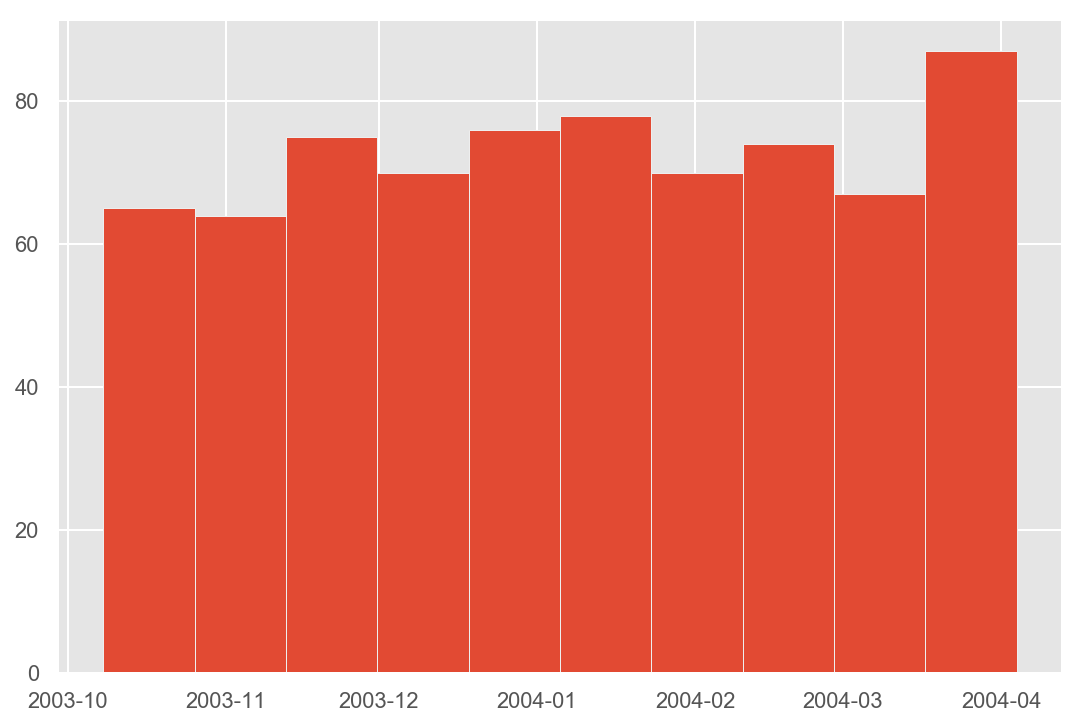

In [10]:
df.date.hist()

In [31]:
df.columns

Index(['season', 'game_number', 'team_name', 'date', 'pull_period',
       'pull_time', 'goal_for_time', 'goal_against_time', 'game_end_time',
       'goal_for_timedelta', 'goal_against_timedelta', 'game_end_timedelta'],
      dtype='object')

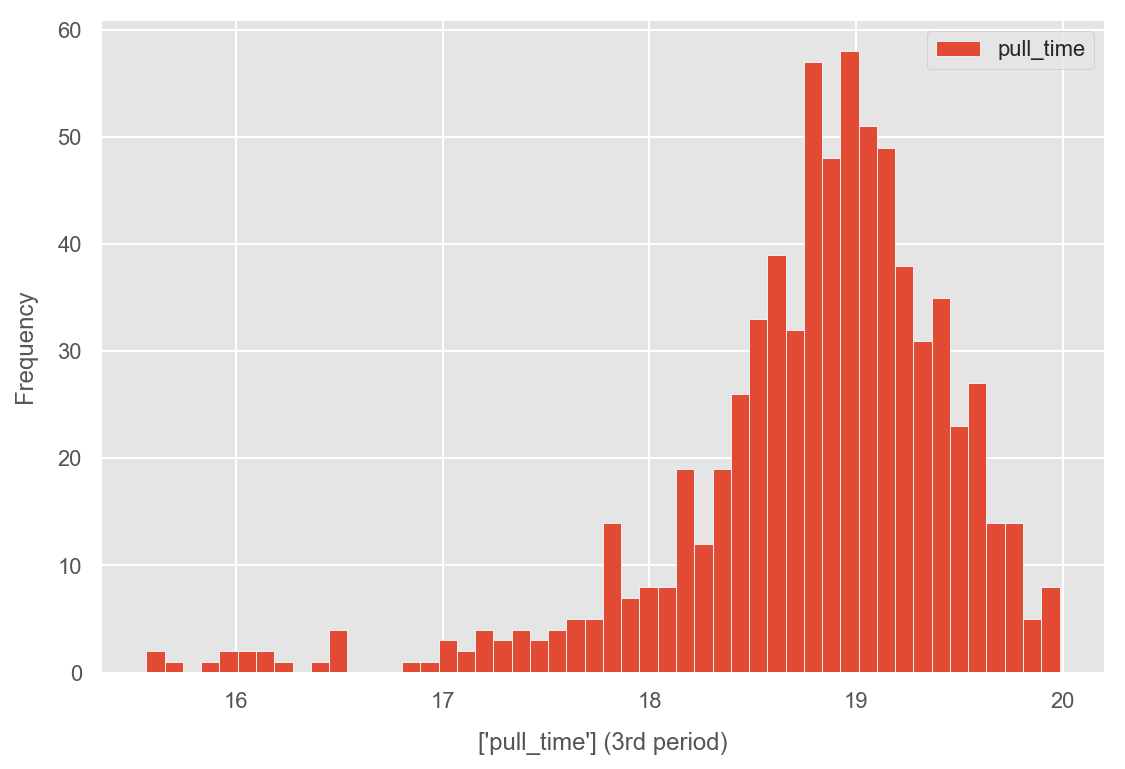

In [43]:
col = ['pull_time']
(df[col].astype('timedelta64[s]') / 60).plot.hist(bins=50)
plt.xlabel(f'{col} (3rd period)');

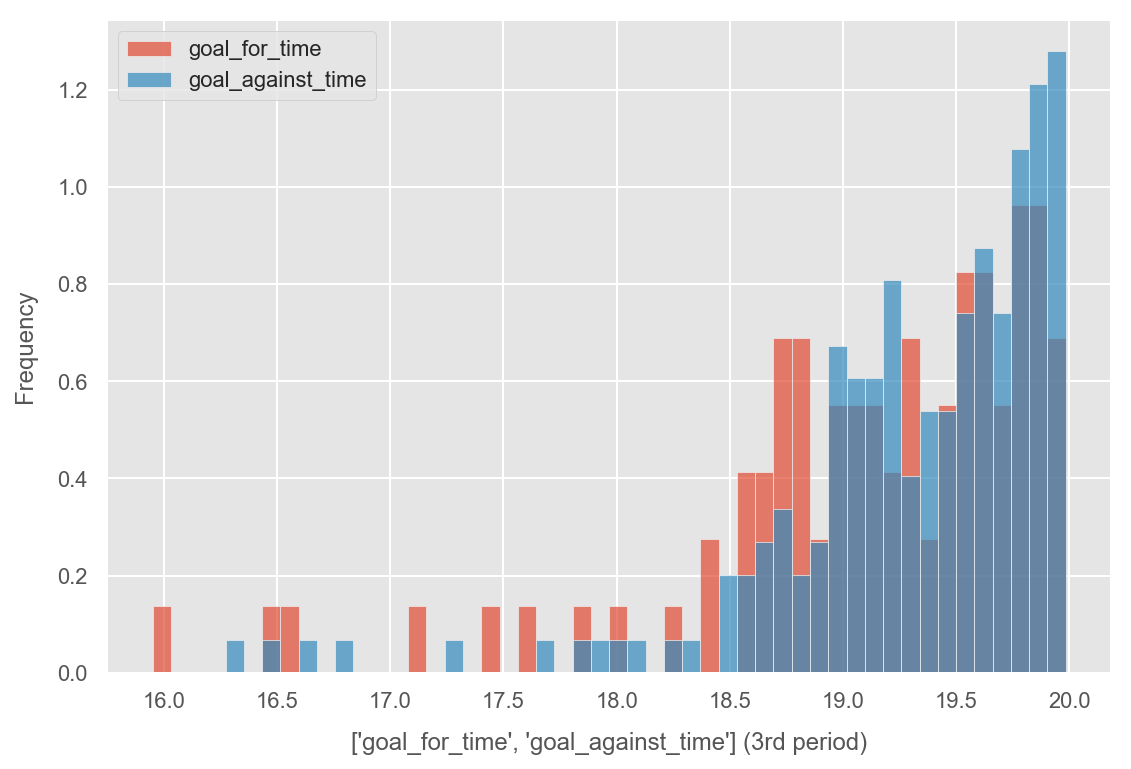

In [58]:
cols = ['goal_for_time', 'goal_against_time']
(df[cols].astype('timedelta64[s]') / 60).plot.hist(bins=50, alpha=0.7, density='normed')
plt.xlabel(f'{cols} (3rd period)');

In [59]:
print('Number of goals found:')
(~df[['goal_for_time', 'goal_against_time']].isnull()).sum()

Number of goals found:


goal_for_time         90
goal_against_time    184
dtype: int64

In [60]:
print('Total goals found:')
(~df[['goal_for_time', 'goal_against_time']].isnull()).sum().sum()

Total goals found:


274

We want to model the time between goalie pull and goal (i.e. the timedelta).

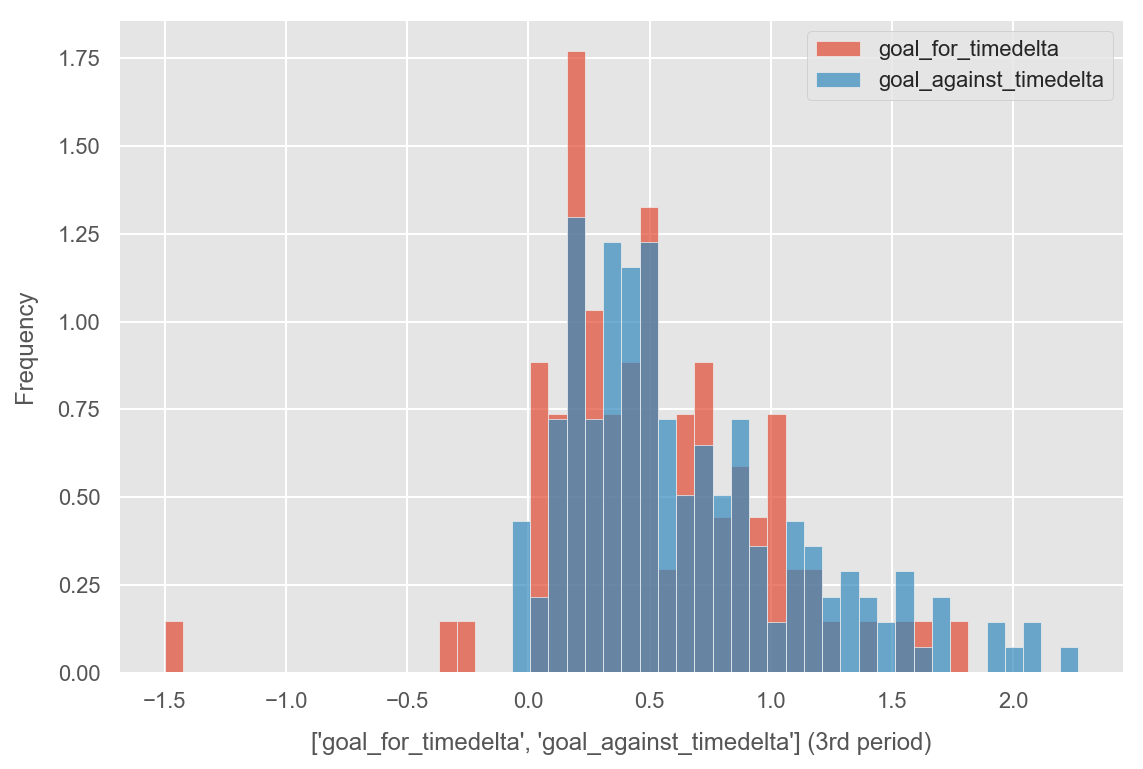

In [61]:
cols = ['goal_for_timedelta', 'goal_against_timedelta']
(df[cols].astype('timedelta64[s]') / 60).plot.hist(bins=50, alpha=0.7, density='normed')
plt.xlabel(f'{cols} (3rd period)');

Anything below 0 doesn't make sense ^

The mean/median number of seconds until a goal (after pulling the goalie)

In [63]:
(df[cols].astype('timedelta64[s]')).mean()

goal_for_timedelta        30.933333
goal_against_timedelta    39.239130
dtype: float64

In [66]:
(df[cols].astype('timedelta64[s]')).median()

goal_for_timedelta        29.5
goal_against_timedelta    30.5
dtype: float64